In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pptx import Presentation
from pptx.util import Inches
import seaborn as sns


In [6]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100
reviews = []

for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    print(f"   ---> {len(reviews)} total reviews")


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [7]:
# Creating DataFrame
df = pd.DataFrame()
df["reviews"] = reviews

# Saving reviews to CSV
df.to_csv("C:/Users/dinesh mishra/OneDrive/New_Folder/British_Airways_revies_analysis_with_pptx/data/ba_reviews.csv", index=False)


In [8]:
# Data Cleaning
def clean_text(text):
    text = re.sub(r'\n', ' ', text)  # Remove newline characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    return text

df['cleaned_review'] = df['reviews'].apply(clean_text)


In [9]:
# Sentiment Analysis
df['sentiment'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))


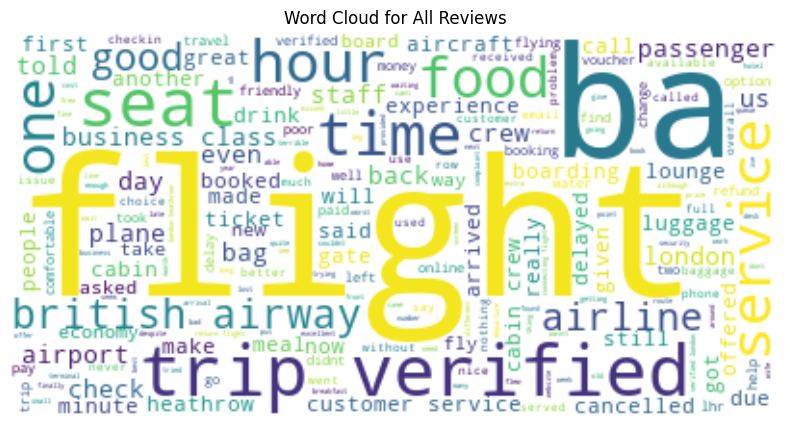

In [10]:
# Generate Word Cloud
text = " ".join(review for review in df.cleaned_review)
wordcloud = WordCloud(background_color="white").generate(text)

# Plotting Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for All Reviews")
plt.show()

# Save Word Cloud image
wordcloud_image_path = 'wordcloud.png'
wordcloud.to_file(wordcloud_image_path)


In [11]:
# Plotting Sentiment Distribution
sentiment_counts = df['sentiment_label'].value_counts()
fig, ax = plt.subplots()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm', ax=ax)
ax.set_title('Sentiment Distribution')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.tight_layout()

# Save the plot as an image
sentiment_distribution_image_path = 'sentiment_distribution.png'
plt.savefig(sentiment_distribution_image_path)
plt.close(fig)


C:\Users\dinesh mishra\AppData\Local\Temp\ipykernel_17484\1531111418.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm', ax=ax)


In [12]:
# Vectorizing text data for LDA
vectorizer = CountVectorizer(stop_words='english')
data_vectorized = vectorizer.fit_transform(df.cleaned_review)

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(data_vectorized)

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_n - 1:-1]])

print_topics(lda, vectorizer)


Topic 0:
['flight', 'ba', 'verified', 'trip', 'london', 'hours', 'told', 'service', 'british', 'customer']
Topic 1:
['ba', 'flight', 'verified', 'trip', 'service', 'crew', 'class', 'business', 'seats', 'cabin']
Topic 2:
['flight', 'good', 'verified', 'food', 'ba', 'trip', 'seat', 'service', 'class', 'time']
Topic 3:
['airways', 'british', 'luggage', 'ba', 'verified', 'staff', 'flight', 'th', 'london', 'trip']
Topic 4:
['amsterdam', 'london', 'flight', 'attendant', 'verified', 'seat', 'business', 'bangkok', 'asked', 'mins']


In [13]:
# Create PowerPoint presentation
prs = Presentation()

# Title Slide
slide = prs.slides.add_slide(prs.slide_layouts[0])
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "Customer Reviews Analysis"
subtitle.text = "An analysis of customer reviews for British Airways"

# Data Cleaning Slide
slide = prs.slides.add_slide(prs.slide_layouts[1])
title, content = slide.shapes.title, slide.placeholders[1]
title.text = "Data Cleaning"
content.text = "The reviews were cleaned to remove unnecessary characters and standardized to lowercase for analysis."

# Sentiment Analysis Slide
slide = prs.slides.add_slide(prs.slide_layouts[1])
title, content = slide.shapes.title, slide.placeholders[1]
title.text = "Sentiment Analysis"
content.text = "Sentiment analysis was performed to classify the reviews into positive, negative, and neutral sentiments."

# Insert Word Cloud Image
slide = prs.slides.add_slide(prs.slide_layouts[5])
title = slide.shapes.title
title.text = "Word Cloud for All Reviews"
left = Inches(1)
top = Inches(1.5)
width = Inches(8.5)
height = Inches(5)
slide.shapes.add_picture(wordcloud_image_path, left, top, width, height)

# Sentiment Distribution Slide with Image
slide = prs.slides.add_slide(prs.slide_layouts[5])
title = slide.shapes.title
title.text = "Sentiment Distribution"
slide.shapes.add_picture(sentiment_distribution_image_path, left, top, width, height)

# Rating Analysis Slide
verified_counts = df['reviews'].apply(lambda x: 'Trip Verified' if 'Trip Verified' in x else 'Not Verified').value_counts()
slide = prs.slides.add_slide(prs.slide_layouts[1])
title, content = slide.shapes.title, slide.placeholders[1]
title.text = "Rating Analysis"
content.text = f"Verified Reviews: {verified_counts['Trip Verified']}\nNon-Verified Reviews: {verified_counts['Not Verified']}"



In [14]:
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [15]:
print(df.isnull().sum())

reviews            0
cleaned_review     0
sentiment          0
sentiment_label    0
dtype: int64


In [16]:
df['verified'] = df['reviews'].apply(lambda x: 'Trip Verified' if 'Trip Verified' in x else 'Not Verified')
df['cleaned_review'] = df['cleaned_review'].apply(lambda x: re.sub(r'trip verified|not verified', '', x))



In [17]:
df['sentiment'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))


In [18]:
verified_counts = df['verified'].value_counts()
sentiment_counts = df['sentiment_label'].value_counts()


In [19]:
positive_reviews = ' '.join(df[df['sentiment_label'] == 'positive']['cleaned_review'])
negative_reviews = ' '.join(df[df['sentiment_label'] == 'negative']['cleaned_review'])


In [20]:
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)


In [21]:
from pptx.util import Inches

# Create a new slide with a blank layout
slide = prs.slides.add_slide(prs.slide_layouts[5])

# Add title using the title placeholder (index 0)
title_shape = slide.shapes.title
title_shape.text = "Word Cloud for Positive Reviews"

# Save the word cloud image
positive_wordcloud.to_file('positive_wordcloud.png')

# Add the word cloud image to the slide
img_path = 'positive_wordcloud.png'
slide.shapes.add_picture(img_path, Inches(2), Inches(1.5), width=Inches(6), height=Inches(3.5))


In [22]:
from pptx.util import Inches

# Create a new slide with a blank layout
slide = prs.slides.add_slide(prs.slide_layouts[5])

# Add title using the title placeholder (index 0)
title_shape = slide.shapes.title
title_shape.text = "Word Cloud for Negative Reviews"

# Save the word cloud image
negative_wordcloud.to_file('negative_wordcloud.png')

# Add the word cloud image to the slide
img_path = 'negative_wordcloud.png'
slide.shapes.add_picture(img_path, Inches(2), Inches(1.5), width=Inches(6), height=Inches(3.5))


In [23]:
prs.save('New_analysis.pptx')